In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from utils import LDA, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN

## **Loading the Data**

The IRIS dataset is loaded from the `sklearn.datasets` package as a pandas dataframe. To verify if the data is loaded correctly, check the first five rows (head) of the dataframe.
If this step fails, the loading of the data is incorrect.

In [2]:
# Load the data
data: dict[str, np.ndarray] = datasets.load_iris()
df: pd.DataFrame = pd.DataFrame(data=data["data"], columns=data["feature_names"])
df["target"] = data["target"]
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### **Preprocessing the Data**

The data is preprocessed to remove the unwanted columns and null values.

In [3]:
# Drop the nan rows
df.dropna(inplace=True)

In [4]:
# Standardize the data
outcome = df["target"]
df.drop("target", axis=1, inplace=True)
df = (df - df.mean()) / df.std()
df["target"] = outcome
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-0.897674,1.015602,-1.335752,-1.311052,0
1,-1.139200,-0.131539,-1.335752,-1.311052,0
2,-1.380727,0.327318,-1.392399,-1.311052,0
3,-1.501490,0.097889,-1.279104,-1.311052,0
4,-1.018437,1.245030,-1.335752,-1.311052,0


### **Data Analysis**

The data is plotted on graphs to find our patterns and relationships among the features.

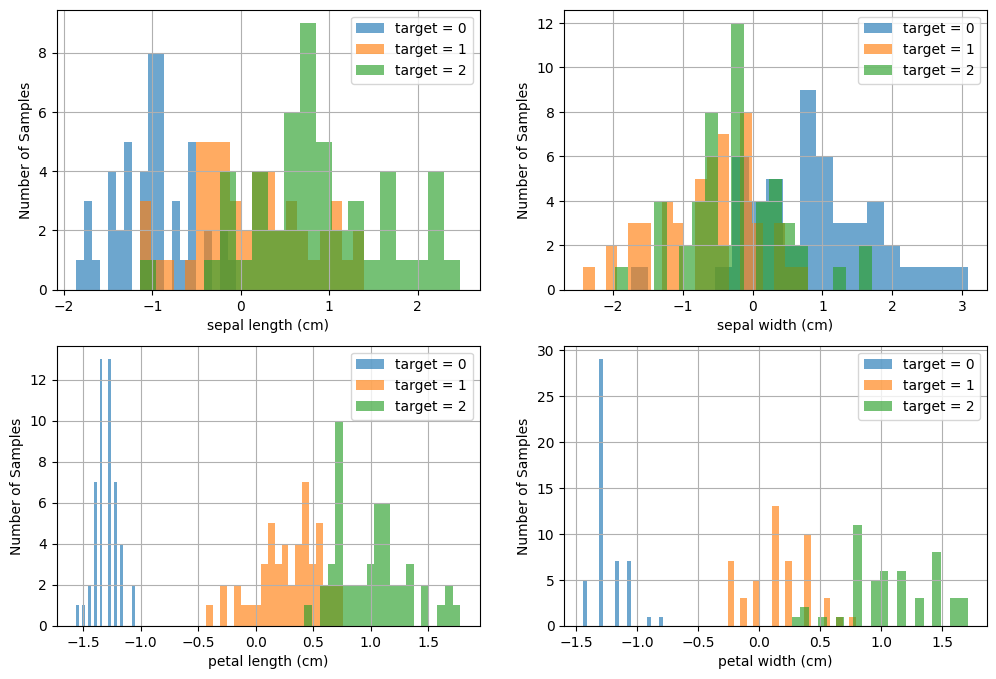

In [5]:
plot = plt.figure(figsize=(12, 8))

for i, col in enumerate(df.columns, start=1):
    if col == "target":
        continue
    else:
        plt.subplot(2, 2, i)

    plt.hist(df[df["target"] == 0][col], bins=20, alpha=0.65, label="target = 0")
    plt.hist(df[df["target"] == 1][col], bins=20, alpha=0.65, label="target = 1")
    plt.hist(df[df["target"] == 2][col], bins=20, alpha=0.65, label="target = 2")

    plt.xlabel(col)

    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.legend()

plt.show()

## **Train-Test Split**

Since the test set is not provided, the training set is split into test sets using a randomized 80-20 split.

In [6]:
# Shuffle the data
train_size: int = int(0.8 * df.shape[0])
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into training and testing
x_train: np.ndarray = df.iloc[:train_size, :-1].values
y_train: np.ndarray = df.iloc[:train_size, -1].values
x_test: np.ndarray = df.iloc[train_size:, :-1].values
y_test: np.ndarray = df.iloc[train_size:, -1].values

### **Perform $k$-Nearest Neighbours**

Having preprocessed and analysed the data, we now perform the $k$-NN algorithm on the original data to get predictions on the test data using $k = 5$.

The accuracy of the model is also calculated.

In [7]:
# Train the model
knn = KNN(n_neighbors=5)
knn.fit(x_train, y_train)

# Check the accuracy
print(f"Accuracy: {knn.score(x_test, y_test) * 100}%")

Accuracy: 90.0%


### **Dimensionality Reduction using LDA**

A copy of the training and testing data is made and its dimensionality is reduced using `LDA` implemented in `utils.py`.

$k$-NN is used on the reduced data to get predictions on the test data using $k = 5$ and the accuracy of both the runs is compared.

In [8]:
# Fit the training data using LDA
trainer = LDA(x_train, y_train)
lda_train = trainer.transform()
print("Transformed Training Data using LDA")

# Fit the testing data using LDA
tester = LDA(x_test, y_test)
lda_test = tester.transform()
print("Transformed Testing Data using LDA")

Transformed Training Data using LDA
Transformed Testing Data using LDA


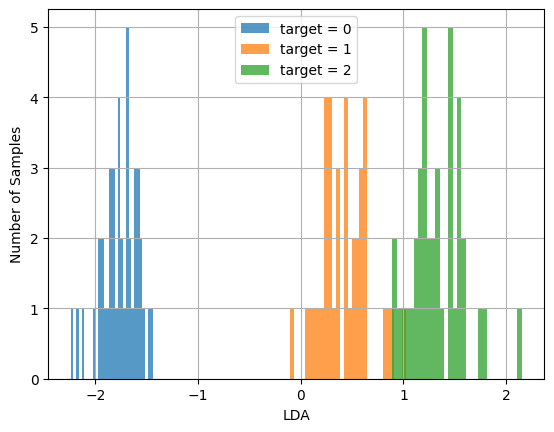

In [9]:
# Plot the data
plt.hist(lda_train[y_train == 0].real, label="target = 0", alpha=0.75, bins=30)
plt.hist(lda_train[y_train == 1].real, label="target = 1", alpha=0.75, bins=30)
plt.hist(lda_train[y_train == 2].real, label="target = 2", alpha=0.75, bins=30)
plt.xlabel("LDA")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# Train the model for the data
lda_train = np.real(lda_train.reshape(-1, 1))
knn = KNN(n_neighbors=5)
knn.fit(lda_train, y_train)

# Calculate the accuracy
lda_test = np.real(lda_test.reshape(-1, 1))
print(f"Accuracy: {knn.score(lda_test, y_test) * 100}%")

Accuracy: 96.66666666666667%


## **Extension of Logistic Regression**

Logistic Regression is generally used for learned binary classification. However, it can be extended to multi-class classification by using two popular approaches:

- **One-vs-Rest Approach:** In this approach, $N$ binary logistic classifiers are trained, where $N$ is the number of labels. Each classifier is trained to distinguish between one class and the rest of the classes. The class with the highest probability is chosen as the predicted class.

- **Multinomial Regression:** This is a more natural extension, and only requires a single classifier to be trained. The classifier is trained on one-hot encoded labels (i.e. each label is represented as a vector of length $N$, where $N$ is the number of labels, and only one element is 1, and the rest are 0). Separate weights are trained for each class, and the class with the highest probability is chosen as the predicted class.

For this question, **Multinomial Regression** has been used for the IRIS dataset.

### **Perform Multinomial Logistic Regression**

The Logistic Regression that solves a binary classification problem can be extended to a multi-class classification problem using the Multinomial approach. To use this approach, the data labels are one-hot encoded. The training labels are hence converted to multi-dimensional vectors.

The `LogisticRegression` class in `utils.py` is a very primitive implementation of the multinomial appproach, and is used to perform classification on the data.

The accuracy of the model is also calculated.

In [11]:
y_train = np.array((y_train == 0, y_train == 1, y_train == 2)).T

In [12]:
# Train the model for the data
model = LogisticRegression(x_train, y_train, alpha=1e-3, tol=1e-4, max_iters=1e+7)
model.train()

# Calculate the accuracy
print(f"Accuracy: {model.accuracy(x_test, y_test) * 100}%")

Accuracy: 90.0%


## **Comparing the Results**

Over multiple runs, it was observed that the accuracy was usually higher with $k$-NN applied on the LDA-preprocessed data. This is because the LDA algorithm finds the best linear combination of features that maximizes the separation between the classes.

However, the LDA+$k$-NN model is highly sensitive due to the small size of the dataset, and the accuracy of the model can vary drastically depending on the random split of the data into training and testing sets.

The logistic regression model is also highly sensitive to the random train-test split, but is comparitively more stable and almost always performs very well.